In [ ]:
# Installing packages

# !pip3 install --user tensorflow_hub
# !pip3 install --user pillow
# !pip3 install --user --upgrade cython
# !pip3 install --user pycocotools
# !pip3 install --user scikit-learn
# !pip3 install --user tensorflow
# !pip3 install matplotlib
!pip3 install nbresuse
!pip3 install keras

In [1]:
# Importing libraries

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import glob
import IPython
from PIL import Image
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split

import time
import sys
from matplotlib import pyplot as plt

# For confusion matrix and analysis
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import collections

/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

# Helper Functions

In [12]:
# Function to assess memory usage at any point in time

def mem_usage():
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    mem_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
    
    sum_bytes = sum([x[1] for x in mem_objects])
    sum_kb = sum_bytes/1000
    sum_mb = sum_kb/1000
    sum_gb = sum_mb /1000
    
    print("Objects in memory: ", mem_objects)
    print('Total memory used: {}GB'.format(sum_gb))

In [4]:
# Cropping a center square from an image
# Danger is that trash could be excluded by accident

def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

In [85]:
#Creating function to print confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
#     y_true = np.array(y_true)   # have to convert to arrays so we can use unique_labels() on them
#     y_pred = np.array(y_pred)
    classes = classes[unique_labels(y_true, y_pred)]

# No need to print basic confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize = (7,7))   # this line here to change the size
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Loading Datasets

### Loading TACO Data

In [5]:
# Loading TACO data

# Timing how long it takes to load data
start = time.time()

## load taco dataset
TACO_PATH = 'TACO/data/'

taco_train_X = []
taco_train_Y = []


globbed_path = glob.glob(TACO_PATH+'*/*.jpg') + glob.glob(TACO_PATH+'*/*.JPG')
print(len(globbed_path))

paths = time.time()

for impath in globbed_path:
    im = Image.open(impath)
    w, h = im.size
    im = crop_center(im, min(w,h), min(w,h))
    im = im.resize((224,224))
    im = np.asarray(im)/256.0
    if im.shape == (224, 224, 3):
        taco_train_X.append(im)
        taco_train_Y.append(0)   # TACO images are labelled 0

print(len(taco_train_X))

end = time.time()

print('Time taken: {}s'.format(end-start))

1500
1500
Time taken: 359.0083396434784s


In [21]:
mem_usage()

Objects in memory:  []
Total memory used: 0.0GB


### Loading COCO data

In [14]:
# Selecting a subset of COCO images to load

coco=COCO('COCO/annotations/instances_train2017.json')

start = time.time()

cats = coco.loadCats(coco.getCatIds())

# nms=[cat['name'] for cat in cats]
# print('COCO categories: \n{}\n'.format(' '.join(nms)))

# nms = set([cat['supercategory'] for cat in cats])
# print('COCO supercategories: \n{}'.format(' '.join(nms)))

# no people, animals, boats and planes, or anything indoors
blacklist_id = [cat['id'] for cat in cats if cat['name'] in ['person', 'airplane', 'boat'] or cat['supercategory'] in ['animal','indoor']]
# take images of hydrants and benches that are likely pointed down at the ground 
whitelist_ids = [cat['id'] for cat in cats if cat['name'] in ['fire hydrant', 'bench']]

image_ids = set()

# add in category whitelists
for catId in whitelist_ids:
    for imgid in coco.getImgIds(catIds=catId):
        image_ids.add(imgid)
        
# remove category blacklists
for catId in blacklist_id:
    for imgid in coco.getImgIds(catIds=catId):
        if imgid in image_ids:
            image_ids.remove(imgid)

image_ids = list(image_ids)
print(len(image_ids))

end = time.time()

print('Time taken: {}s'.format(end-start))

loading annotations into memory...
Done (t=18.40s)
creating index...
index created!
1858
Time taken: 0.04860091209411621s


In [15]:
# Loading COCO data

COCO_PATH = 'COCO/train2017/'
coco_train_X = []
coco_train_Y = []

print(len(image_ids))

for imid in image_ids:
    im = Image.open(COCO_PATH + "{0:012d}.jpg".format(imid))
    w, h = im.size
    im = crop_center(im, min(w,h), min(w,h))
    im = im.resize((224,224))
    im = np.asarray(im)/256.0
    if im.shape == (224, 224, 3):
        coco_train_X.append(im)
        coco_train_Y.append(1)   # COCO images are labelled 1


print(len(coco_train_X))

1858
1857


In [17]:
    # These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mem_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

sum_bytes = sum([x[1] for x in mem_objects])
sum_kb = sum_bytes/1000
sum_mb = sum_kb/1000
sum_gb = sum_mb /1000

print("Objects in memory: ", mem_objects)
print('Total memory used: {}GB'.format(sum_gb))

Objects in memory:  [('im', 1204352), ('image_ids', 16832), ('coco_train_X', 16560), ('coco_train_Y', 16560), ('taco_train_X', 13008), ('taco_train_Y', 13008), ('globbed_path', 12064), ('COCO', 1184), ('cats', 768), ('blacklist_id', 264), ('crop_center', 136), ('mem_usage', 136), ('train_test_split', 136), ('whitelist_ids', 96), ('Image', 80), ('hub', 80), ('np', 80), ('tf', 80), ('impath', 79), ('COCO_PATH', 64), ('TACO_PATH', 59), ('coco', 56), ('catId', 28), ('h', 28), ('imgid', 28), ('imid', 28), ('w', 28), ('end', 24), ('paths', 24), ('start', 24)]
Total memory used: 0.0012958940000000001GB


### EDA

In [ ]:
# TACO EDA

IPython.display.Image(filename = globbed_path[0])

# Note that in batch 1, 35 to 61 aren't trash, more like household items
# batch 3 first few seem to be top downs like the recycling trashnet images
# some images are close up, some are further away

In [ ]:
# COCO EDA

IPython.display.Image(filename = "COCO/train2017/{0:012d}.jpg".format(image_ids[3]))

# Splitting into train and test sets

In [18]:
# Combining TACO and COCO data
X_all = np.array(taco_train_X + coco_train_X)
Y_all = np.array(taco_train_Y + coco_train_Y)

# Splitting combined data into train and test sets
X_train, X_val, Y_train, Y_val = train_test_split(X_all, Y_all, test_size=0.1, random_state=42)

Objects in memory:  []
Total memory used: 0.0GB


# Fitting RESNET-50 Model

In [20]:
# Define model
resnet = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4",
                   trainable=False),  # Can be True.
    tf.keras.layers.Dense(1, activation='sigmoid')
])
resnet.build([None, 224, 224, 3])  # Batch input shape.

# Compile model
resnet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.
print(resnet.summary())

# adding early stopping to model
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5)
    
# saving the best model for evaluation
mc = ModelCheckpoint('best_resnet.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only=True)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mem_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

sum_bytes = sum([x[1] for x in mem_objects])
sum_kb = sum_bytes/1000
sum_mb = sum_kb/1000
sum_gb = sum_mb /1000

print("Objects in memory: ", mem_objects)
print('Total memory used: {}GB'.format(sum_gb))

Objects in memory:  [('X_all', 4042580112), ('X_train', 3637960848), ('X_val', 404619408), ('im', 1204352), ('Y_all', 26952), ('Y_train', 24264), ('image_ids', 16832), ('coco_train_X', 16560), ('coco_train_Y', 16560), ('taco_train_X', 13008), ('taco_train_Y', 13008), ('globbed_path', 12064), ('Y_val', 2784), ('COCO', 1184), ('cats', 768), ('mem_objects', 376), ('blacklist_id', 264), ('crop_center', 136), ('mem_usage', 136), ('train_test_split', 136), ('whitelist_ids', 96), ('Image', 80), ('hub', 80), ('np', 80), ('tf', 80), ('impath', 79), ('COCO_PATH', 64), ('TACO_PATH', 59), ('coco', 56), ('model', 56), ('catId', 28), ('h', 28), ('imgid', 28), ('imid', 28), ('sum_bytes', 28), ('w', 28), ('end', 24), ('paths', 24), ('start', 24), ('sum_gb', 24), ('sum_kb', 24), ('sum_mb', 24)]
Total memory used: 8.086510794GB


In [23]:
resnet.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks = [es, mc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3021 samples, validate on 336 samples
Epoch 1/10
3021/3021 [==============================] - 125s 41ms/sample - loss: 0.7325 - acc: 0.5866 - val_loss: 0.5776 - val_acc: 0.7054
Epoch 2/10
3021/3021 [==============================] - 120s 40ms/sample - loss: 0.4860 - acc: 0.7690 - val_loss: 0.4300 - val_acc: 0.8155
Epoch 3/10
3021/3021 [==============================] - 119s 39ms/sample - loss: 0.3711 - acc: 0.8491 - val_loss: 0.3556 - val_acc: 0.8690
Epoch 4/10
3021/3021 [==============================] - 118s 39ms/sample - loss: 0.3084 - acc: 0.8808 - val_loss: 0.3117 - val_acc: 0.8780
Epoch 5/10
3021/3021 [==============================] - 118s 39ms/sample - loss: 0.2692 - acc: 0.9017 - val_loss: 0.2817 - val_acc: 0.8958
Epoch 6/10
3021/3021 [==============================] - 118s 39ms/sample - loss: 0.2421 - acc: 0.9143 - val_loss: 0.2594 - val_acc: 0.9048
Epoch 7/10
3021/3021 [==============================] - 119s 39ms/sample - loss: 0.2218 - acc: 0.9249 - val_loss: 0.242

In [ ]:
#plot learning curves for accuracy
plt.plot(resnet.history.history['accuracy'], label = 'train')
plt.plot(resnet.history.history['val_accuracy'], label = 'dev')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')

# Residual Analysis of RESNET-50 model

In [53]:
#Obtaining probabilities of predictions
probs = model.predict(X_val)   #Apparently this gives you probs instead of labels

# Reshaping so that we can pass it into plot_confusion_matrix later
probs2 = np.reshape(probs, 336)

#Converting probabilities to one-hot predictions
preds = (probs2>0.5).astype(np.int)


In [62]:
import collections
collections.Counter(Y_val)

# 0 is TACO, which is trash

Counter({0: 171, 1: 165})

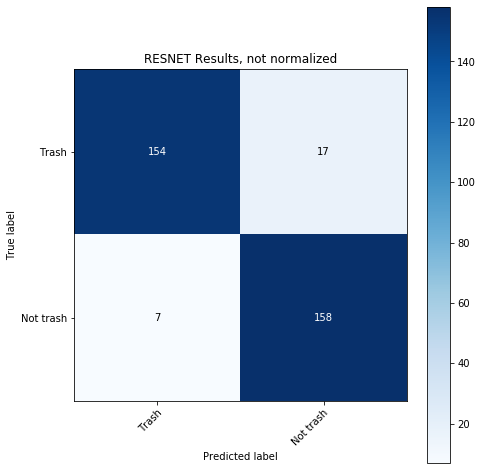

In [86]:
plot_confusion_matrix(y_true = Y_val , y_pred = preds , classes = np.array(['Trash', 'Not trash']) , title = 'RESNET Results, not normalized')

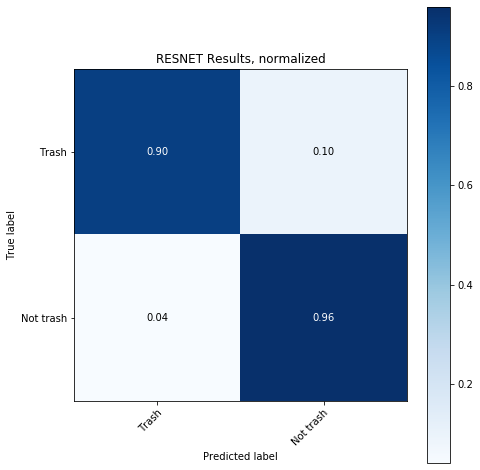

In [87]:
plot_confusion_matrix(y_true = Y_val , y_pred = preds , classes = np.array(['Trash', 'Not trash']) , title = 'RESNET Results, normalized', normalize = True)

In [74]:
# Obtaining indices for misclassified images

misclass = []
index = 0

for truth, pred in zip(Y_val, preds):
    
    if truth != pred:
        
        # Misclassified it as trash when clean
        if truth == 1:
            misclass.append((index, 'Trash when clean' ))
        
        elif truth == 0:
            misclass.append((index, 'Clean when trash' ))           
    
    index += 1

print(misclass)

[(5, 'Trash when clean'), (31, 'Clean when trash'), (48, 'Trash when clean'), (49, 'Clean when trash'), (64, 'Clean when trash'), (71, 'Trash when clean'), (72, 'Trash when clean'), (93, 'Clean when trash'), (104, 'Clean when trash'), (115, 'Clean when trash'), (123, 'Clean when trash'), (134, 'Clean when trash'), (144, 'Clean when trash'), (146, 'Trash when clean'), (160, 'Clean when trash'), (183, 'Trash when clean'), (184, 'Trash when clean'), (198, 'Clean when trash'), (235, 'Clean when trash'), (245, 'Clean when trash'), (263, 'Clean when trash'), (285, 'Clean when trash'), (311, 'Clean when trash'), (320, 'Clean when trash')]


In [76]:
misclass[2][1]

'Trash when clean'

Trash when clean


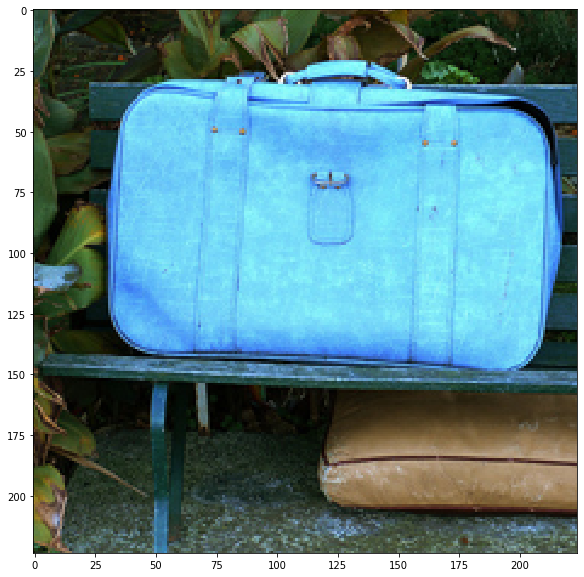

Clean when trash


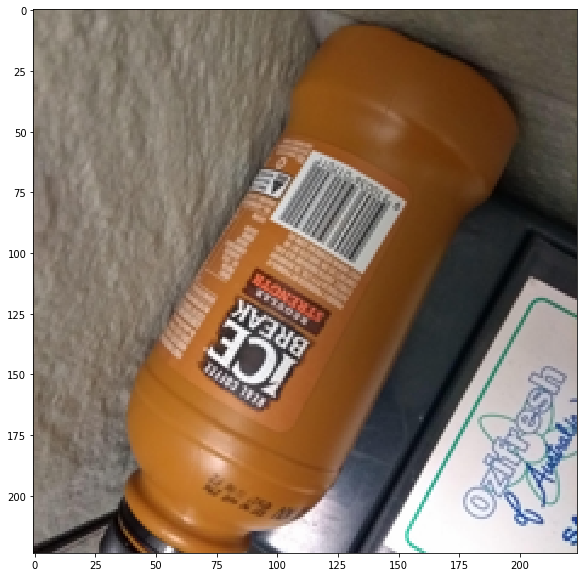

Trash when clean


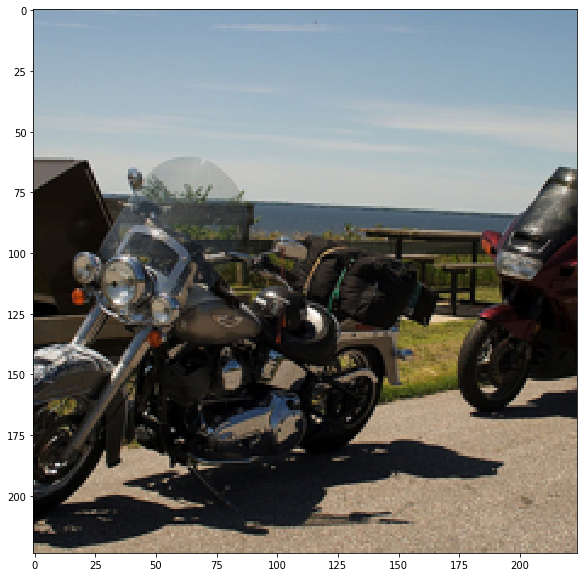

Clean when trash


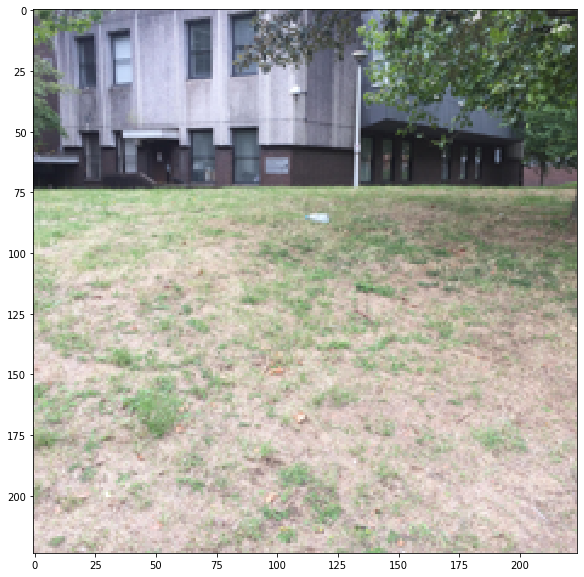

Clean when trash


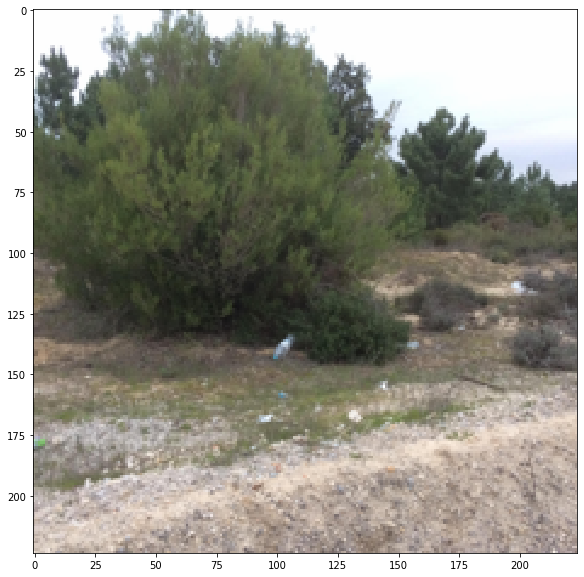

Trash when clean


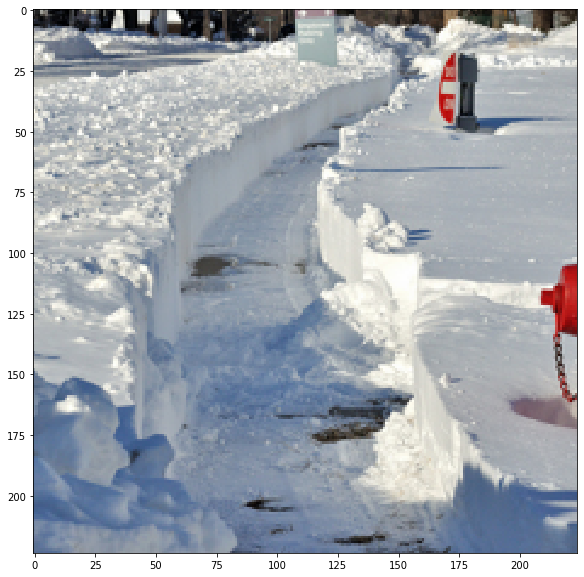

Trash when clean


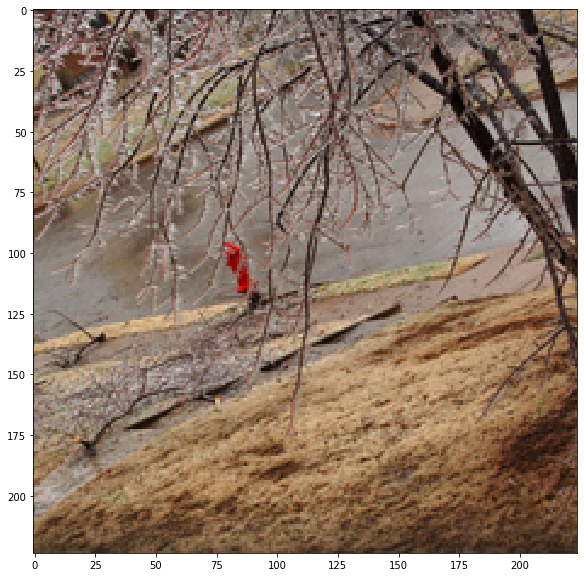

Clean when trash


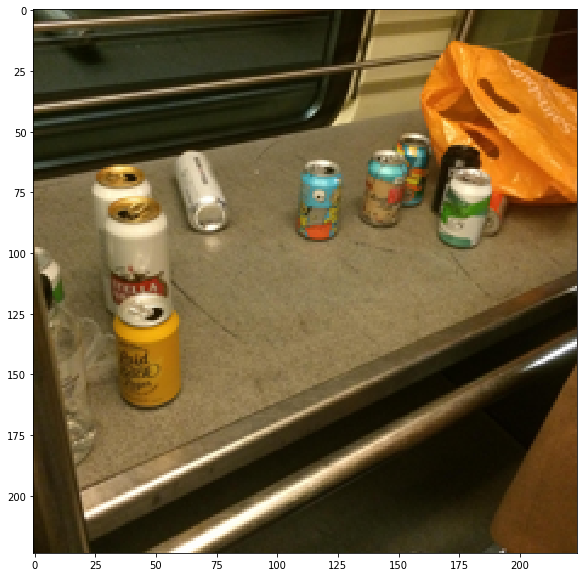

Clean when trash


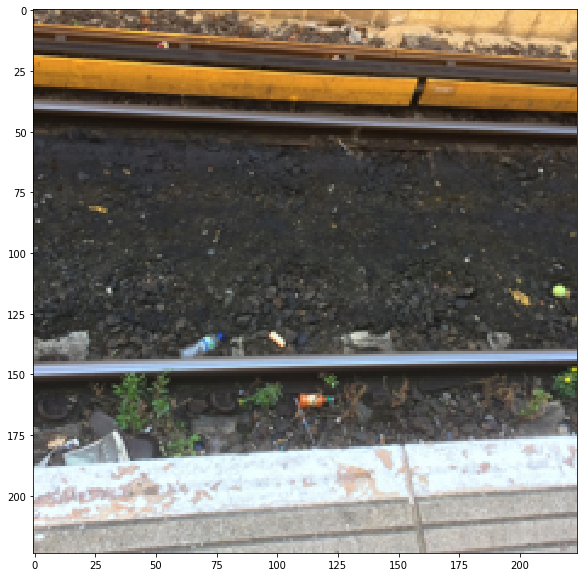

Clean when trash


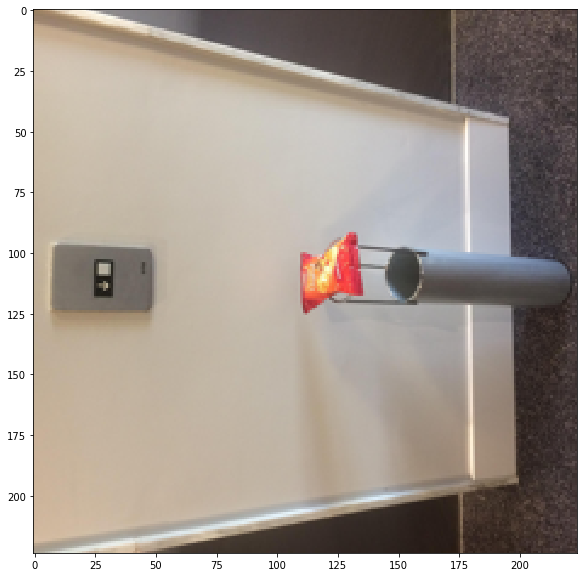

Clean when trash


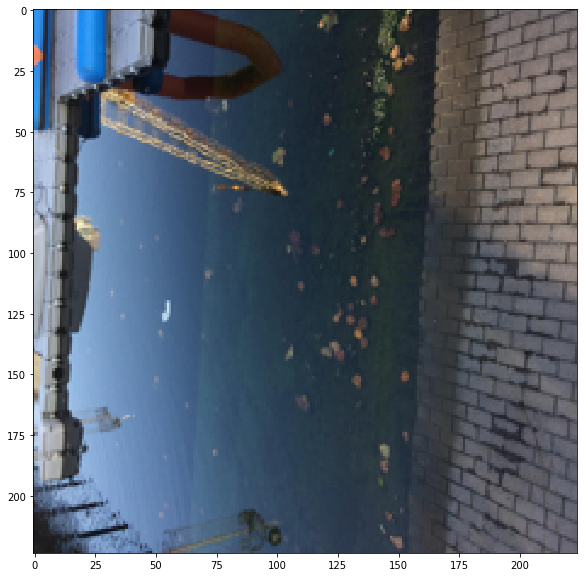

Clean when trash


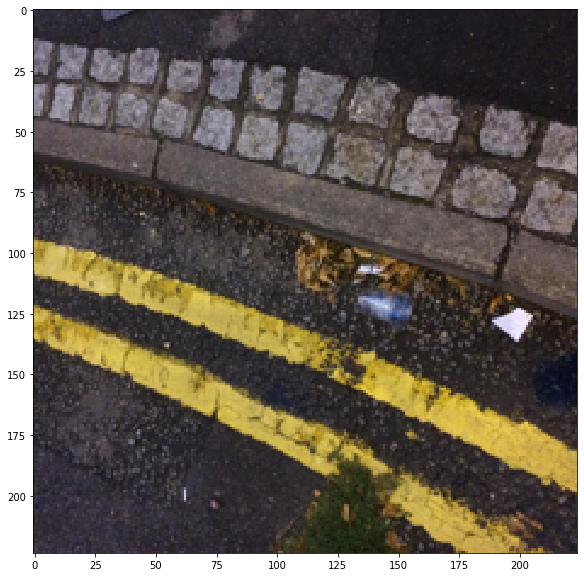

Clean when trash


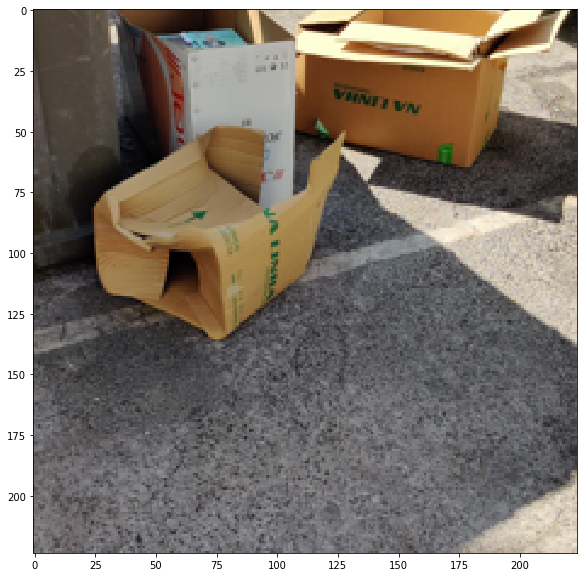

Trash when clean


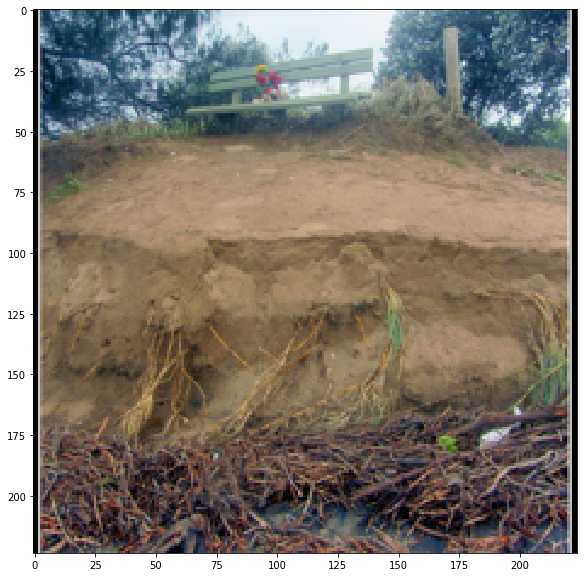

Clean when trash


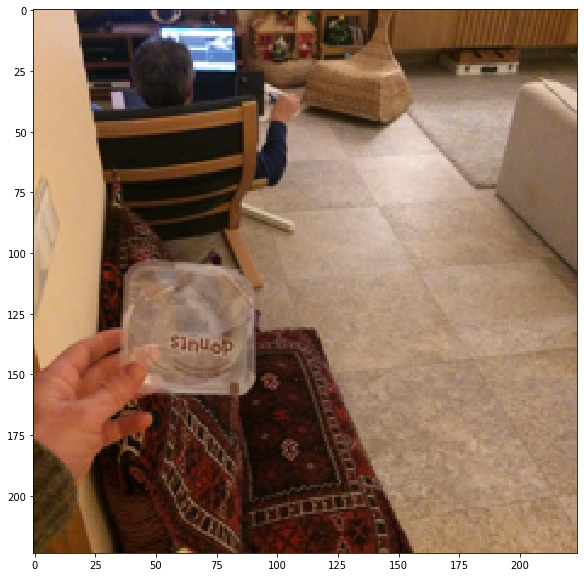

Trash when clean


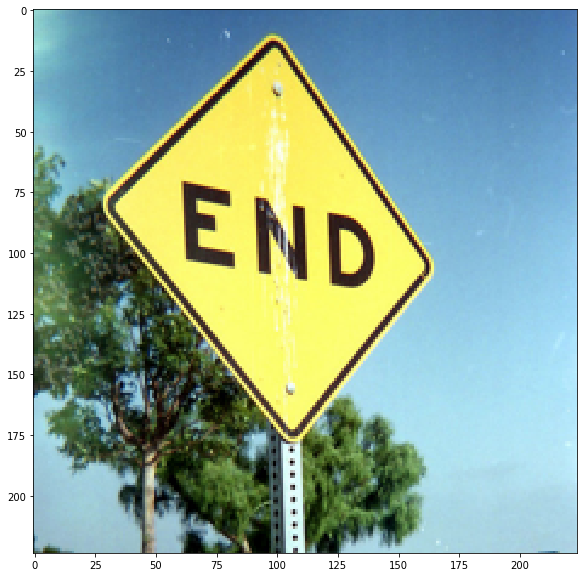

Trash when clean


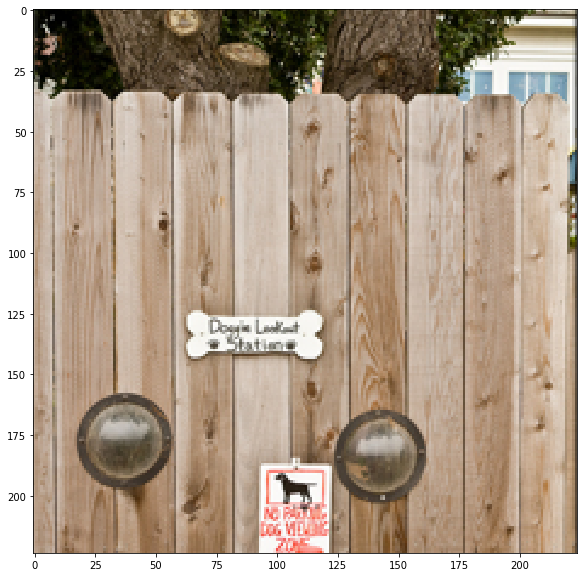

Clean when trash


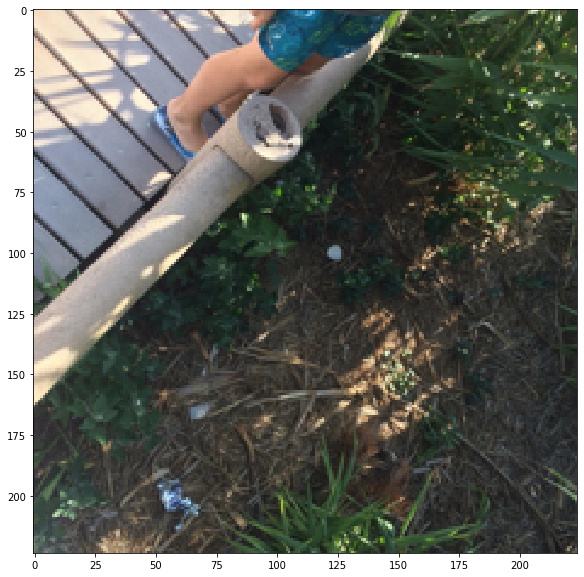

Clean when trash


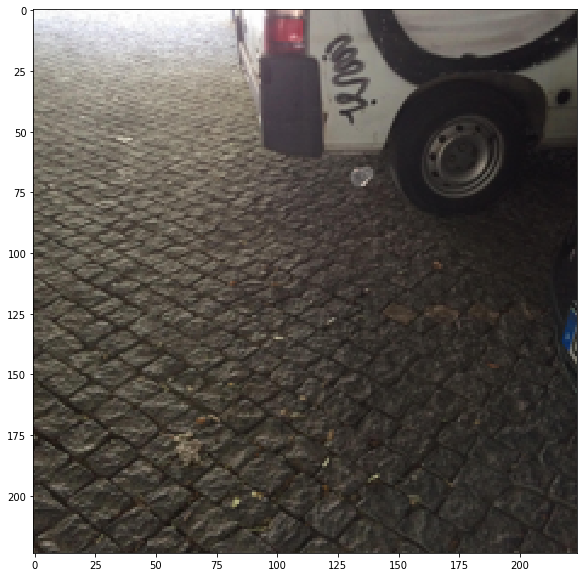

Clean when trash


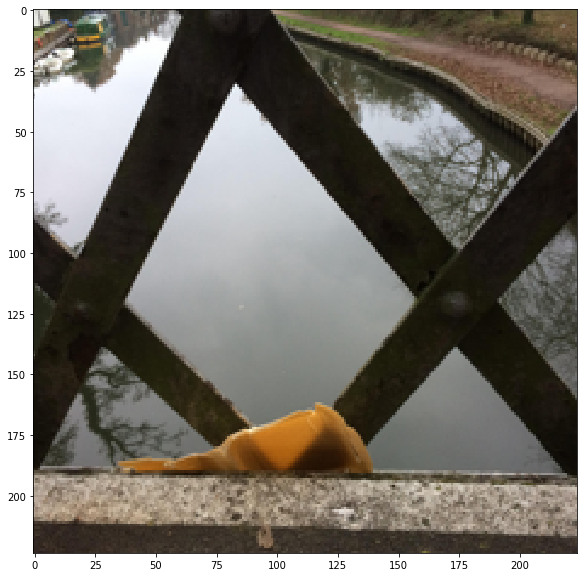

Clean when trash


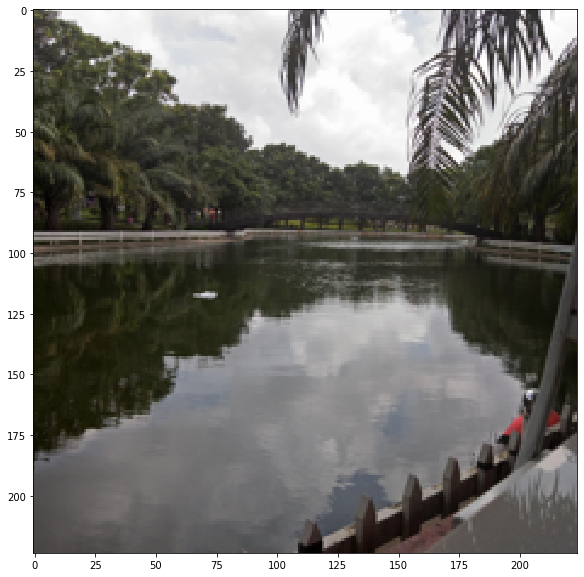

Clean when trash


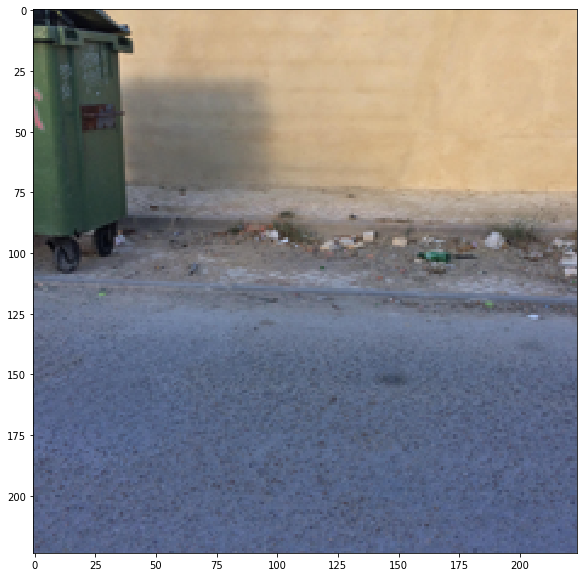

Clean when trash


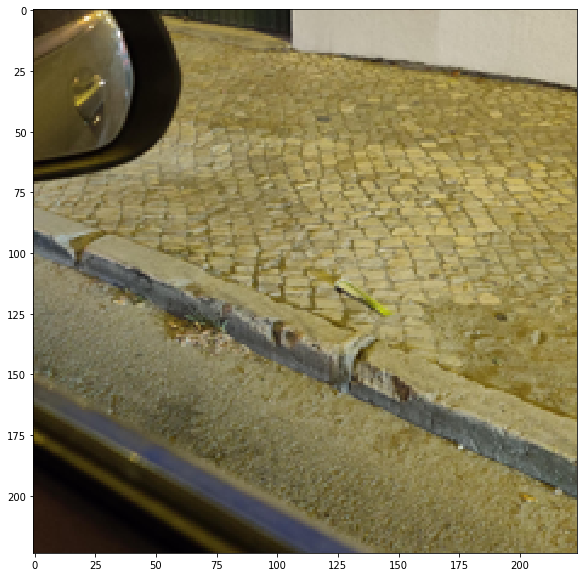

Clean when trash


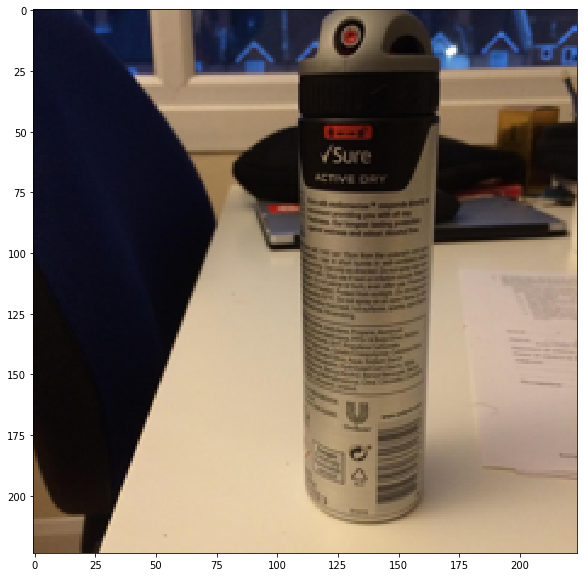

In [81]:
# Printing misclassified images

# Iterating through misclassified indices
for i, z in zip ([x[0] for x in misclass], range(len(misclass))):
    
    # Labelling the image with what kind of misclassification error
    print(misclass[z][1])
    
    # Displaying the image
    plt.figure(figsize = (10,10))
    plt.imshow(X_val[i], interpolation='nearest')
    plt.show()

In [70]:
from PIL import Image

w, h = 224, 224
data = np.zeros((h, w, 3), dtype=np.uint8)
data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
img = Image.fromarray(data, 'RGB')
# img.save('my.png')
img.show()

In [ ]:
# Need to print cropped images to see what they look like

A few takeaways so far:

Seems to predict 'clean when trash' when the trash is quite small - but need to check against a sample of correctly predicted images

Also seems to predict 'clean when trash' when the trash is super obvious, so maybe it doesn't realise that that's trash, thinks it belongs

Seems to predict 'trash when clean' when the object is something very close 





### Next steps

Figure out a way to store the images so don't have to resort to using matplotlib
Look at correctly classified images

Check for indoors vs outdoors

fix mem_usage function

Evaluate Brandon's model

Change 1 to trash and 0 for clean



Objects in memory:  []
Total memory used: 0.0GB
